<a href="https://colab.research.google.com/github/mylee99125/CS-Final-Semester/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [ ]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

In [ ]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

- 런타임 -> 세션 다시 시작

In [2]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [3]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [4]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [5]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [6]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


1


In [7]:
set_seed(86)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

2


In [8]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and observing the camera, which has a similar striped pattern as the one depicted on the book cover. The setting appears to be indoors, possibly on a wooden surface or floor.


## 14-5 의류 이미지 여부 판단

In [9]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'Is this a picture of clothing? MUST say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

Yes, this image is of clothing. It features a person wearing a jacket and a shirt, which are the main subjects of the photograph. The focus on the attire suggests that it could be used for fashion-related purposes such as advertising or showcasing a particular style or brand.
Yes, this image appears to be a fashion-oriented photograph showcasing clothing. The individual's attire is the focal point, with an emphasis on style and presentation rather than any specific activity or context. The choice of clothing, including the striped trousers and layered shirts, suggests a deliberate styling that could be used for fashion editorial purposes or as part of a clothing catalog.
Yes.
Yes, the image is of clothing. Specifically, it showcases a pair of shoes which are a type of footwear designed for wearing on the feet. The details such as the materials used (leather and fabric), the construction elements like the strap with grommets, and the distinctive tread pattern on the sole all indicate th

## 14-6 의류 판단 결과 시각화

In [10]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,True
3,,True
4,,False
5,,True
6,,True
7,,True
8,,True
9,,True


## 14-7 의류 이미지 필터링

In [11]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]

## 14-8 의류 스타일 분석

In [13]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of the clothes. Please let me explain the colors and trend changes.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

/tmp/ipython-input-1874085826.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['style'] = df['image'].apply(describe_style)


In [14]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The clothing style depicted in the image leans towards a casual, possibly streetwear aesthetic. The olive green jacket is practical and reminiscent of outdoor or utility wear, often favored for its durability and comfort. It features a hood, which adds to its functionality and suggests a preference for versatile, adaptable pieces that can be worn in various settings.\n\nThe plaid shirt underneath the jacket contributes to a laid-back, yet stylish look. Plaid patterns are timeless but have seen resurgence in popularity within contemporary fashion circles. The beige color of the shirt complements the jacket, creating a cohesive color palette that is both earthy and approachable.\n\nThe brown trousers provide a neutral base that balances the outfit, ensuring it doesn't become too busy with patterns and colors. This choice enhances the overall relaxed vibe while maintaining a polished appearance.\n\nThe combination of these elements—utility-inspired outerwear, a classic plaid shirt, and neutral trousers—reflects a trend towards blending functional pieces with fashionable details. This style is indicative of modern streetwear trends, where comfort meets aesthetics, and practicality is as important as visual appeal."
1,,True,"The clothing style in the image leans towards a contemporary casual-chic aesthetic. The navy blue blazer is a versatile piece that has been popular in men's fashion for its ability to complement various outfits and occasions, from casual to smart-casual settings. Its relaxed fit suggests an influence of modern streetwear trends, which often favor comfort without sacrificing style.\n\nThe brown shirt underneath adds depth and warmth to the ensemble, creating a balanced contrast with the dark blazer. It appears to be a standard button-up shirt, which can be dressed up or down depending on how it's accessorized.\n\nThe striped trousers are particularly striking due to their vertical pinstripes. This pattern is traditionally associated with formal wear but has seen resurgence in more casual contexts, especially within urban fashion circles. The use of such a pattern in non-formal garments like trousers indicates a blending of traditional styles with modern, laid-back aesthetics.\n\nOverall, the outfit reflects a blend of classic tailoring with modern, relaxed elements, suggesting a trend towards versatile, timeless pieces that can be styled in multiple ways to suit different occasions and personal preferences."
2,,True,"The style of the clothes in the image reflects a historical progression of outdoor clothing from 1953 to 2000. The colors are vibrant and functional, with a focus on visibility and practicality for mountain activities. In the early years (1953-1970s), the gear was likely more subdued and less colorful due to the limitations of dyeing techniques and materials. As seen in the magazine cover, there's a noticeable shift towards brighter hues during the late 1970s through the early 2000s.\n\nThis change could be attributed to several factors: advancements in textile technology allowing for more diverse color options, an increased emphasis on safety and visibility in extreme environments, and possibly a cultural shift towards expressing individuality even in utilitarian garments. The trend shows a balance between functionality—necessary for survival and performance—and personal expression, which became more pronounced as outdoor activities like mountaineering gained popularity and evolved into a lifestyle choice."
3,,True,"The shoes in the image exhibit a style that blends elements of casual and rugged design, likely targeting consumers interested in both fashion and practicality. The color palette is earthy, with beige and olive green being prominent, which suggests an inspiration from military or outdoor gear aesthetics. This choice of colors often conveys durability and versatility, appealing to those who seek shoes that can transition between different settings, such 

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [15]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', gpu_memory_utilization=0.5, max_model_len=10000)

INFO 01-17 14:23:17 __init__.py:207] Automatically detected platform cuda.
INFO 01-17 14:23:18 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 01-17 14:23:41 config.py:549] This model supports multiple tasks: {'generate', 'reward', 'score', 'classify', 'embed'}. Defaulting to 'generate'.
INFO 01-17 14:23:41 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 01-17 14:24:27 model_runner.py:1115] Loading model weights took 4.5146 GB
INFO 01-17 14:24:30 worker.py:267] Memory profiling takes 2.52 seconds
INFO 01-17 14:24:30 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 01-17 14:24:30 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.86GiB.
INFO 01-17 14:24:31 executor_base.py:111] # cuda blocks: 1625, # CPU blocks: 3495
INFO 01-17 14:24:31 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.60x
INFO 01-17 14:24:36 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:40<00:00,  1.17s/it]

INFO 01-17 14:25:17 model_runner.py:1562] Graph capturing finished in 41 secs, took 0.21 GiB
INFO 01-17 14:25:17 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 49.13 seconds


## 14-10 색상 정보 추출

In [16]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 색상 외에 다른 정보는 적지 말아주세요.\n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 01-17 14:25:46 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, est. speed input: 438.20 toks/s, output: 33.36 toks/s]


- 올리브 그린 (Olive Green)
- 베이지 (Beige)
- 갈색 (Brown)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, est. speed input: 497.41 toks/s, output: 34.19 toks/s]


- **네이비 블루** (Navy Blue)
- **브라운** (Brown)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it, est. speed input: 237.32 toks/s, output: 37.14 toks/s]


- **1953-1970s**: Subdued colors
- **Late 1970s - Early 2000s**: Bright hues


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, est. speed input: 425.46 toks/s, output: 33.59 toks/s]


**색상:**
- 베이지 (Beige)
- 올리브 그린 (Olive Green)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s, est. speed input: 861.60 toks/s, output: 26.41 toks/s]


- 밝은 오렌지
- 파란색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s, est. speed input: 556.52 toks/s, output: 30.92 toks/s]


- 어두운 네이비 (Dark Navy)
- 밝은 파란색 (Light Blue)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it, est. speed input: 193.90 toks/s, output: 37.90 toks/s]


- **맨의 옷**: sleeveless vest (셔츠 없는 조끼)
- **여성의 옷**: dark blouse (어두운 블라우스), subtle checkered pattern (부드러운 체크 패턴), high-waisted trousers (높은 허리 바지)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s, est. speed input: 1136.53 toks/s, output: 22.02 toks/s]


색상: 어두운 회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s, est. speed input: 583.50 toks/s, output: 30.93 toks/s]


- 베이지 (Beige)
- 라이트 그린 (Light Green)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s, est. speed input: 406.50 toks/s, output: 34.63 toks/s]


- **khaki**
- **navy blue**
- **beige**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, est. speed input: 502.20 toks/s, output: 33.35 toks/s]

색상:
- 갈색 (brown)
- 베이지색 (tan)



/tmp/ipython-input-537633341.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['style'].apply(extract_color)


## 14-11 스타일 키워드 추출

In [17]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_style(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출해주세요. 스타일 키워드 외에 다른 정보는 적지 말아주세요.\n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_style 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_style)

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s, est. speed input: 296.08 toks/s, output: 35.61 toks/s]


- 캐주얼
- 스트리트웨어
- 실용적
- 후드
- 빈티지한 패턴
- 베이지색
- 중립적
- 편안함과 스타일의 조화


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, est. speed input: 157.79 toks/s, output: 37.16 toks/s]


- **현대적**
- **캐주얼**
- **치크**
- **다양성**
- **현대 스트리트웨어**
- **깊이**
- **따뜻함**
- **전통적 패턴**
- **현대적 활용**
- ** Versatile**
- **타임리스**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it, est. speed input: 165.04 toks/s, output: 35.63 toks/s]


- **기능성**
- **실용성**
- **가시성**
- **색상 다양성**
- **색상 변화**
- **안전성**
- **개인 표현**
- **문화적 변화**
- **활동 인기화**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it, est. speed input: 170.68 toks/s, output: 36.94 toks/s]


- **실용성**
- **실용적 디자인**
- **아웃도어**
- **다목적**
- **현대적**
- **기능성**
- **강인함**
- **기능성과 패션**
- **다양성**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, est. speed input: 143.91 toks/s, output: 36.66 toks/s]


- 캐주얼한 스타일
- 스트리트웨어 영감
- 밝은 오렌지와 블루의 대조적 색상
- 시각적 흥미 유발을 위한 색상 조합
- 레이어드 룩
- 깊이감 있는 텍스처
- 현대적인 도시적 감각
- 개인 표현을 위한 색상 조화
- 액세서리 활용 (니트 모자 포함)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it, est. speed input: 186.04 toks/s, output: 38.05 toks/s]


- 스마트 캐주얼 패션
- 클래식
- Versatility
- Timeless Appeal
- 잘 맞음
- 패턴
- 색상 대조
- Nautical Theme
- 전통성
- Cool Undertone
- Layering
- 적응성
- 현대적 접근
- 편안함과 스타일의 조화


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it, est. speed input: 194.01 toks/s, output: 36.20 toks/s]


- **현대적**
- **편안함**
- **레이어링**
- **casual yet smart**
- **텍스처**
- **실루엣**
- **클래식 트렌드**
- **실용성**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it, est. speed input: 194.22 toks/s, output: 37.35 toks/s]


스타일 키워드:
- 미니멀리즘
- 모노크롬
- 언더stated
- sophistication
- 차분함
- 중성성
- 현대적
- 편안함
- 루즈핏
- 심플함
- 지속가능성


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it, est. speed input: 184.59 toks/s, output: 38.21 toks/s]


- 클래식
- 미니멀리스트
- 캐주얼 엘레강스
- 타임리스
- 중성적 톤
- 패턴의 다양성
- 편안함과 패션의 균형
- 테일러드
- 구조적 완성도
- 심플함
- 품질 중시
- 색상의 절제


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it, est. speed input: 192.68 toks/s, output: 38.53 toks/s]


- 캐주얼
- 편안함
- 실용성
- muted 색상
- earthy 톤
- 기능성
- 다양성
- 단순성
- 개인 표현
- eclectic 스타일
- 혼합 및 매치


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it, est. speed input: 184.28 toks/s, output: 37.85 toks/s]

- 클래식하고 영원한 디자인
- 군사적 영감
- 흙빛과 중성적 색상 팔레트
- 자연스러운 톤
- 야외 활동 및 캐주얼 도시 웨어와의 조화
- 실용성과 스타일의 융합
- 지속 가능성과 친환경 소재



/tmp/ipython-input-3012919389.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['style'].apply(extract_style)


In [18]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
0,,True,"The clothing style depicted in the image leans towards a casual, possibly streetwear aesthetic. The olive green jacket is practical and reminiscent of outdoor or utility wear, often favored for its durability and comfort. It features a hood, which adds to its functionality and suggests a preference for versatile, adaptable pieces that can be worn in various settings.\n\nThe plaid shirt underneath the jacket contributes to a laid-back, yet stylish look. Plaid patterns are timeless but have seen resurgence in popularity within contemporary fashion circles. The beige color of the shirt complements the jacket, creating a cohesive color palette that is both earthy and approachable.\n\nThe brown trousers provide a neutral base that balances the outfit, ensuring it doesn't become too busy with patterns and colors. This choice enhances the overall relaxed vibe while maintaining a polished appearance.\n\nThe combination of these elements—utility-inspired outerwear, a classic plaid shirt, and neutral trousers—reflects a trend towards blending functional pieces with fashionable details. This style is indicative of modern streetwear trends, where comfort meets aesthetics, and practicality is as important as visual appeal.",- 올리브 그린 (Olive Green)\n- 베이지 (Beige)\n- 갈색 (Brown),- 캐주얼\n- 스트리트웨어\n- 실용적\n- 후드\n- 빈티지한 패턴\n- 베이지색\n- 중립적\n- 편안함과 스타일의 조화
1,,True,"The clothing style in the image leans towards a contemporary casual-chic aesthetic. The navy blue blazer is a versatile piece that has been popular in men's fashion for its ability to complement various outfits and occasions, from casual to smart-casual settings. Its relaxed fit suggests an influence of modern streetwear trends, which often favor comfort without sacrificing style.\n\nThe brown shirt underneath adds depth and warmth to the ensemble, creating a balanced contrast with the dark blazer. It appears to be a standard button-up shirt, which can be dressed up or down depending on how it's accessorized.\n\nThe striped trousers are particularly striking due to their vertical pinstripes. This pattern is traditionally associated with formal wear but has seen resurgence in more casual contexts, especially within urban fashion circles. The use of such a pattern in non-formal garments like trousers indicates a blending of traditional styles with modern, laid-back aesthetics.\n\nOverall, the outfit reflects a blend of classic tailoring with modern, relaxed elements, suggesting a trend towards versatile, timeless pieces that can be styled in multiple ways to suit different occasions and personal preferences.",- **네이비 블루** (Navy Blue)\n- **브라운** (Brown),- **현대적**\n- **캐주얼**\n- **치크**\n- **다양성**\n- **현대 스트리트웨어**\n- **깊이**\n- **따뜻함**\n- **전통적 패턴**\n- **현대적 활용**\n- ** Versatile**\n- **타임리스**
2,,True,"The style of the clothes in the image reflects a historical progression of outdoor clothing from 1953 to 2000. The colors are vibrant and functional, with a focus on visibility and practicality for mountain activities. In the early years (1953-1970s), the gear was likely more subdued and less colorful due to the limitations of dyeing techniques and materials. As seen in the magazine cover, there's a noticeable shift towards brighter hues during the late 1970s through the early 2000s.\n\nThis change could be attributed to several factors: advancements in textile technology allowing for more diverse color options, an increased emphasis on safety and visibility in extreme environments, and possibly a cultural shift towards expressing individuality even in utilitarian garments. The trend shows a balance between functionality—necessary for survival and performance—and personal expression, which became more pronounced as outdoor activities like mountaineering gained popularity and evolved into a lifestyle choice.",- **1953-1970s**: Subdued colors\n- **Late 1970s - Early 2000s**: Bright hues,- **기능성**\n- **실용성**\n- **가시성**\n- **색상 다양성**\n- **색상 변화**\n- **안전성**

## 14-12 텍스트 데이터 정제

In [19]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

/tmp/ipython-input-2796376683.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['color'].apply(clean_text)
/tmp/ipython-input-2796376683.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['keyword'].apply(clean_text)


## 14-13 워드 클라우드 생성 및 시각화

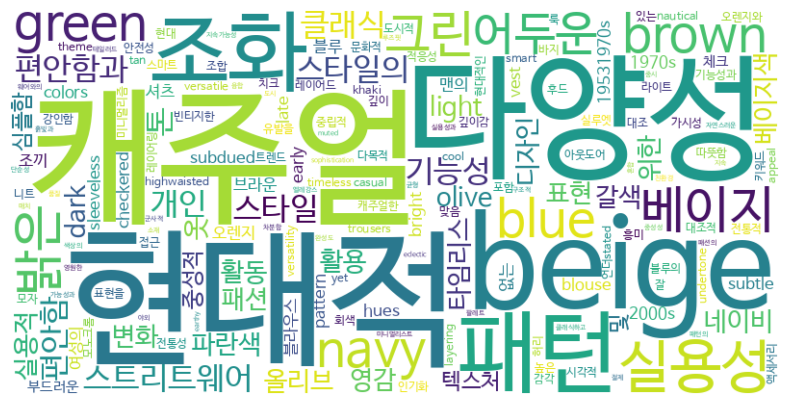

In [23]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud.to_image(), interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [21]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노트:{row.style}\n이미지 url:{row.image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트렌드 방향의 분석 보고서를 작성해주세요. 보고서의 제목은 해외 룩북 스타일 분석입니다. 내용은 전문적이면서 명확하게 작성해주세요. 문서 형식은 markdown으로 만들어주세요."})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:23<00:00, 23.06s/it, est. speed input: 140.27 toks/s, output: 37.85 toks/s]


In [22]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 룩북 스타일 분석 보고서

## 개요
본 보고서는 최근 다양한 해외 패션 룩북에서 관찰되는 주요 트렌드를 분석하고, 이를 통해 미래의 패션 경향을 예측하는 데 초점을 맞춥니다. 특히, 다양한 이미지와 스타일 요소를 바탕으로 한 분석 결과를 종합하여 현대 패션의 핵심 특징을 도출합니다.

## 트렌드 분석

### 1. **미니멀리즘과 기능성의 융합**
- **분석**: 최근 패션 트렌드는 단순함과 실용성을 강조하는 미니멀리즘이 두드러집니다. 예를 들어, **Verytage**와 **Manual Alphabet**의 룩북에서 보이는 것처럼, 단색과 중성적인 색상 팔레트가 주를 이루며, **Verytage**의 체크셔츠와 **Manual Alphabet**의 베이지색 셔츠는 편안함과 세련됨을 동시에 제공합니다.
- **예측**: 지속적인 환경 의식과 함께, 품질과 내구성에 중점을 둔 제품이 더욱 선호될 것으로 예상됩니다.

### 2. **실용성과 스타일의 균형**
- **분석**: **Officine Generale**과 **Beams Plus**의 이미지에서 보이는 것처럼, 클래식한 요소와 현대적인 감각이 조화롭게 결합됩니다. **Officine Generale**의 스마트 캐주얼 스타일과 **Beams Plus**의 오버사이즈 셔츠는 편안함과 세련됨을 동시에 제공합니다.
- **예측**: 다양한 상황에 유연하게 대응할 수 있는 다기능적인 의류가 계속해서 인기를 얻을 것으로 보입니다.

### 3. **스트리트웨어와 클래식의 융합**
- **분석**: **Remi Relief**와 **KICS Document**의 룩북은 스트리트웨어의 캐주얼한 요소와 클래식한 디자인의 조화를 보여줍니다. **Remi Relief**의 밝은 오렌지와 네이비 조합, **KICS Document**의 striped trousers는 현대적인 감각과 전통적인 패턴의 융합을 잘 보여줍니다.
- **예측**: 스트리트웨어의 자유로움과 클래식의 정교함이 결합된 스타일이 지속적으로 주목받을 것으로 예상됩니다.

### 4. **실용성과 개성의 조화**
- **분석**: **Yashiki**와 **Verytage**의 룩북은 실용적인 소재와 디자인을 통해 개성 표현을 강조합니다. **Yashiki**의 minimalist outfit과 **Verytage**의 체크셔츠와 tailored trousers는 편안함과 개성적인 스타일을 동시에 추구합니다.
- **예측**: 개인의 취향과 실용성을 동시에 만족시키는 제품이 더욱 중요해질 것으로 보입니다. 특히, 지속 가능한 패션 요소가 이러한 트렌드를 더욱 강화할 것으로 예상됩니다.

### 5. **기능성과 스타일의 결합**
- **분석**: **William Eggleston**의 이미지에서 보이는 것처럼, **Visvim**의 Brigadier Mid-Folk 부츠는 기능성과 스타일을 동시에 제공합니다. **Visvim**의 부츠는 자연스러운 색상과 내구성 있는 디자인으로 실용성과 패션성을 균형 있게 결합합니다.
- **예측**: 환경 친화적이고 내구성이 뛰어난 소재를 사용한 기능성 신발이 지속적으로 인기를 얻을 것으로 보입니다.

## 결론
최근 패션 트렌드는 미니멀리즘과 실용성의 조화, 클래식 요소와 현대적 감각의 융합, 그리고 개인의 개성 표현과 기능성의 균형을 중심으로 발전하고 있습니다. 이러한 경향은 지속 가능성과 환경 의식의 증가와 맞물려, 미래 패션은 더욱 다양성과 실용성을 겸비한 방향으로 진화할 것으로 예상됩니다. 이러한 분석을 바탕으로 패션 브랜드와 디자이너들은 고객의 요구와 시장의 변화를 적극적으로 반영한 제품 개발에 주력할 필요가 있습니다.

---

이 보고서는 주어진 이미지와 스타일 요소를 바탕으로 한 종합적인 분석을 통해 현대 패션의 주요 트렌드를 명확히 제시하고자 작성되었습니다.